Event Study: Cybersecurity Breaches Effects on Stock Price

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

<h2>Data Collection and Processing</h2> 

We will be using the <a href= "https://wrds-www.wharton.upenn.edu/">WRDS</a> (Wharton Research Data Services) database to find financial analyst predictions on stock price using their <a href= "https://wrds-www.wharton.upenn.edu/pages/support/support-articles/ibes/about-ibes/">IBES</a> dataset. The WRDS database is provided to all UMD staff and students for free, you can sign up for an account <a href="https://wrds-www.wharton.upenn.edu/register/">here</a>. When running this following section of code, you must supply your account's credentials. We recommend setting up a <a href = "https://matteocourthoud.github.io/post/wrds/"> pgpass</a> to help automate the process.

In [2]:
db = wrds.Connection()

Enter your WRDS username [gabri]:gnaval
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


We will be using the Audit Analytics February 2021 issue of cybersecurity databreaches.

In [3]:
# Audit Analytics Dataset
xls = pd.ExcelFile('../data/audit_analytics.xlsx')
aa_records_df = pd.read_excel(xls, 'PublicCyber')
aa_ddos_df = pd.read_excel(xls, 'DDoS')

# Get rid of rows with no tickers (these might be not publicly traded companies)
aa_records_df = aa_records_df[aa_records_df['Ticker'].isna() != True].reset_index(drop=True)
table_columns = ['Company name', 'Ticker', 'Date of Breach', 'Date Became Aware of Breach', 'Date of Disclosure',
                 'Number of Records', 'Type of Info', 'Information', 'Attack', 'Region', 'SIC Code']
aa_records_df = aa_records_df[aa_records_df.columns.intersection(table_columns)]

In [5]:
today = datetime.datetime.today().date()

def nearest(items, pivot):
    """
    Gets closest day in a set (used to obtain stock price y months after disclosure)
    """
    return min(items, key=lambda x: abs((x - pivot).days))

def stock_after_disclosure(row, num_months):
    """
    Returns an array containing the monthly stock price of a firm after date of disclosure (0 - num_months months after breach).
    If firm exists in YahooFinance database, but no stock price available for a month (either b/c that date has yet to occur or b/c simply N/A),
    returns np.nan.
    If firm does not exist in YahooFinance database, return array of np.nan's.
    
    Parameters: 
    row : Dataframe row
        Input dataframe's row (used along with df.apply)
    num_months : int
        Month limit
    """
    start = pd.to_datetime(row['Date of Disclosure']) 
    end = start + pd.DateOffset(months = num_months)
    # Don't know if i should include this, check stock day before breach to control for large stock dip when breach is disclosed
    start -= datetime.timedelta(days=1) 
    #print(row['Ticker'])
    try:
        df = web.DataReader(row['Ticker'], 'yahoo', start, end)
        #display(df)
        lst = []
        for month in range(0, num_months + 1):
            date = nearest(df.index, (start + pd.DateOffset(months = month)))
            if today <= date.date():
                for x in range(month, num_months + 1):
                    lst.append(np.nan)
                break
            lst.append(df.loc[date]["Close"])
        return lst
    except Exception as e:
        print("Error at %s" % row['Ticker'])
        print(repr(e))
        return [np.nan] * (num_months + 1)
    
def sic_to_industry(sic_code):
    x = int(sic_code/100)
    if x <= 9:
        return "Agriculture, Forestry, Fishing"
    elif x <= 14:
        return "Mining"
    elif x <= 17: 
        return "Construction"
    elif x <= 39:
        return "Manufacturing"
    elif x <= 49: 
        return "Transportation & Public Utilities"
    elif x <= 51:
        return "Wholesale Trade"
    elif x <= 59:
        return "Retail Trade"
    elif x <= 67:
        return "Finance, Insurance, Real Estate"
    elif x <= 89:
        return "Services"
    elif x <= 99:
        return "Public Administration"
    return "N/A"

In [6]:
lst = []
months_after = 12 #Toggle this value
col = []
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

In [ ]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
for index, row in aa_records_df.iterrows():
    x = stock_after_disclosure(row, months_after)
    lst.append(x)

In [ ]:
# Merge stock price after breach with original dataframe
stock_prices = pd.DataFrame(lst, columns = col)
stock_price_aa_records = pd.concat([aa_records_df, stock_prices], axis=1, join='inner')

In [15]:
def analyst_stock_price(row):
    """
    Returns the median and mean of analyst stock price forecasts for a firm, where the forecasts are within a month after the beach. 
    These forecasts predict the stock price 12 months into the future.
    
    Parameters
        row - Dataframe row
        Input dataframe's row (used along with df.apply)
    Returns
        List of length 2. [median, mean]
    """
    date = pd.to_datetime(row['Date of Disclosure'])
    
    sql_query="""
    SELECT VALUE as stock_price
    FROM ibes.ptgdet
    WHERE OFTIC ='{}' AND CAST(HORIZON as int) = 12 AND ANNDATS BETWEEN '{}' and '{}'
    """.format(row['Ticker'], date, date + pd.DateOffset(months = 1))
    
    df = db.raw_sql(sql_query)
    
    if len(df.index) == 0:
        return [np.nan] * 2
    return [df['stock_price'].median(), df['stock_price'].mean()]
    

In [ ]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
lst = []
for index, row in stock_price_aa_records.iterrows():
    lst.append(analyst_stock_price(row))
    
# Merge stock price after breach with original dataframe
median_mean_df = pd.DataFrame(lst, columns = ['median stock forecast', 'mean stock forecast'])
stock_price_aa_records = pd.concat([stock_price_aa_records, median_mean_df], axis=1, join='inner')

In [3]:
# Cleaning and Dummy encoding
stock_price_aa_records['Type of Info'] = stock_price_aa_records['Type of Info'].str.replace(" ", "")
stock_price_aa_records['Attack'] = stock_price_aa_records['Attack'].str.replace("; ", "|")
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Type of Info', 1), stock_price_aa_records['Type of Info'].str.get_dummies(sep="|").add_suffix(" (Type of Info)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Attack', 1), stock_price_aa_records['Attack'].str.get_dummies(sep="|").add_suffix(" (Attack)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('SIC Code', 1), stock_price_aa_records['SIC Code'].str.get_dummies(sep="|").add_suffix(" (Industry)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Region', 1), stock_price_aa_records['Region'].str.get_dummies(sep="|").add_suffix(" (Region)")], 1)

In [ ]:
"""
It turns out there are A LOT of different types of information released (around ~70) 
and this will probably be correlated to the type of info, so let's just not include this for now
"""
# stock_price_aa_records['Information'] = stock_price_aa_records['Information'].str.replace(" ", "")
# stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Information', 1), stock_price_aa_records['Information'].str.get_dummies(sep="|").add_suffix(" (Information)")], 1)

In [ ]:
# Avoiding the dummy variable trap [https://www.wikiwand.com/en/Dummy_variable_(statistics)]
# Drop ND (Not Disclosed) columns for 'Attack' and 'Type of Info'
stock_price_aa_records.drop(columns = ['ND (Type of Info)', 'ND (Attack)', 'Mining (Industry)', 'Foreign (Region)'], inplace = True)

In [7]:
lst = []
months_after = 12 #Toggle this value
col = []
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

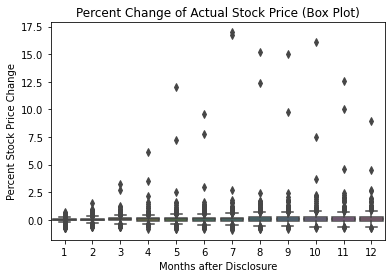

[]

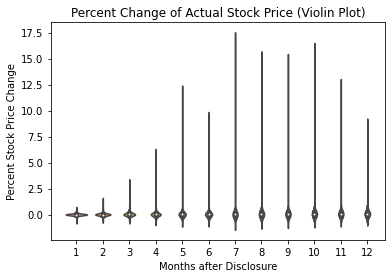

In [22]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: (row[x] - row[col[0]])/row[col[0]], axis = 1)
    n += 1

boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(stock_prices).dropna())
boxplot.set(xlabel="Months after Disclosure", ylabel='Percent Stock Price Change') # Where x month is percent change from start of breach
boxplot.set_title("Percent Change of Actual Stock Price (Box Plot)")
plt.show()

ax = sns.violinplot(x='variable', y='value', data=pd.melt(stock_prices).dropna())

plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
ax.set_title("Percent Change of Actual Stock Price (Violin Plot)")
ax.plot()

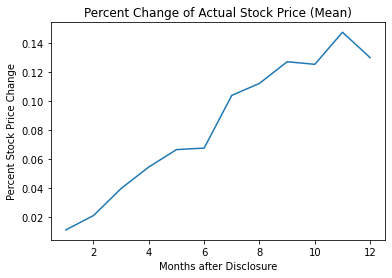

In [64]:
# It appears that, on average, stock price goes up
plt.plot(np.arange(1, 13), stock_prices.mean())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Mean)")
plt.show()

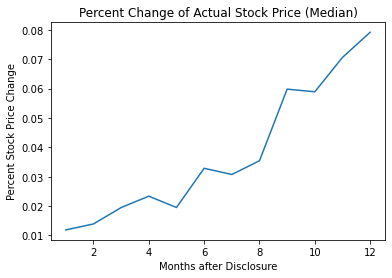

In [26]:
# Let's use median because there are some outliers. Same trend seems to occur
plt.plot(np.arange(1, 13), stock_prices.median())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Median)")
plt.show()

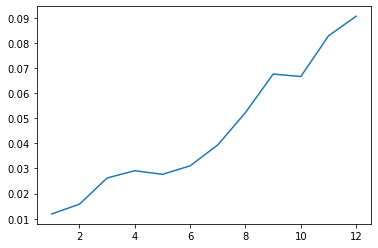

In [11]:
# Let's take 5% trimmed mean (get rid of some outliers)
trimmed_means = []
for x in range(1, months_after + 1):
    trimmed_means.append(stats.trim_mean(stock_prices[x].dropna(), 0.05))
plt.plot(np.arange(1, 13), trimmed_means)
    

In [12]:
test = stock_price_aa_records.drop(columns=['Company name', 'Ticker', 
                                            'Date of Breach', 'Date Became Aware of Breach', 
                                            'Date of Disclosure', 'Information'])
test.drop(columns=col, inplace = True)
test.drop(columns = ['median stock forecast', 'mean stock forecast'], inplace = True)
table = test
table = pd.concat([test, stock_prices], axis=1, join='inner')
display(table)

,Number of Records,Financial (Type of Info),Intrusion (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Malware (Attack),Misconfiguration (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region),1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.087205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.022527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.138929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.025118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.018835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,815,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.108658,0.145811,0.130249,0.077392,0.051945,0.067157,0.050964,-0.004487,0.108447,0.173992,0.177287,0.073607
733,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,-0.151432,0.051842,0.073670,0.051842,0.084584,0.090041,0.096862,0.045020,0.055934,-0.064120,0.054570,0.105048
734,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.011905,-0.029365,-0.060119,-0.058333,-0.076290,-0.014484,-0.000298,0.052579,-0.040972,-0.039286,-0.036607,-0.092064
735,11000000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.045428,-0.039786,-0.021378,-0.080760,-0.077197,-0.155285,-0.126485,-0.105107,-0.083432,-0.233373,-0.294240,-0.125594


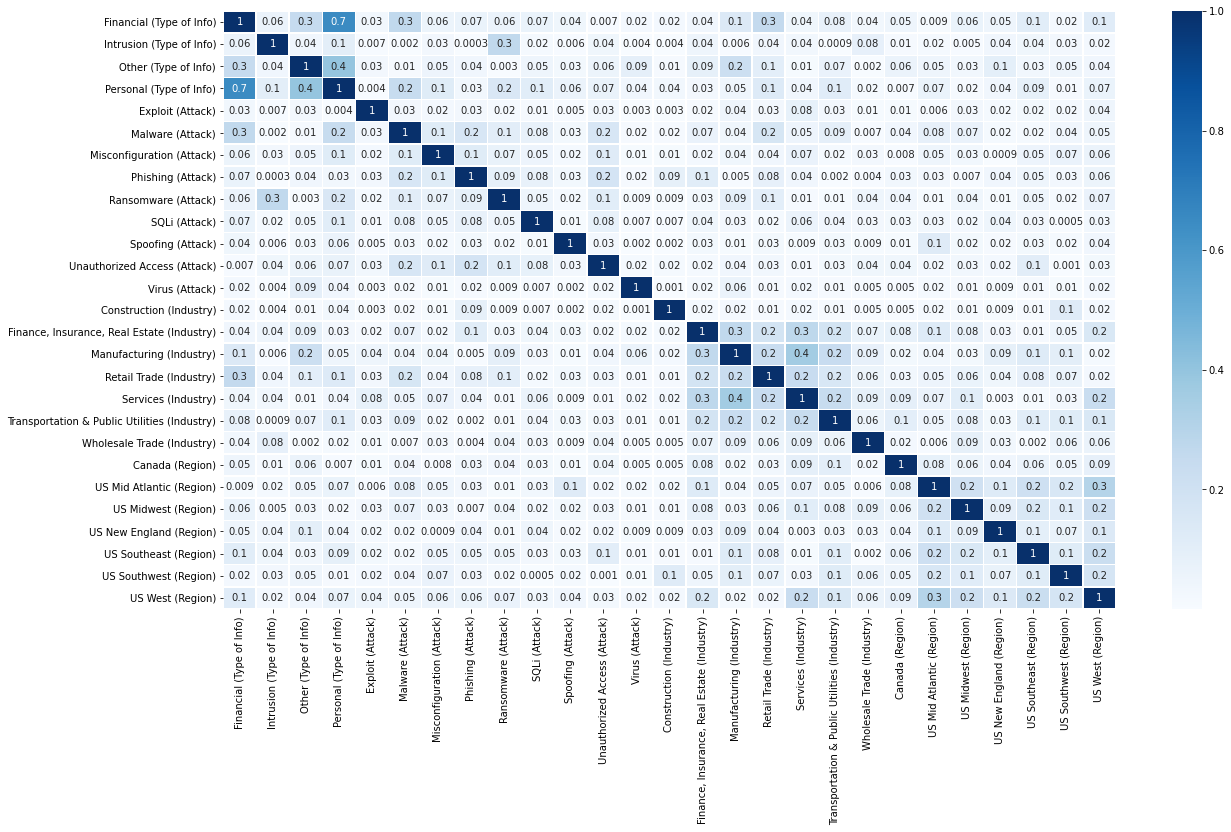

In [15]:
# Correlation matrix using absolute value of correlation
plt.subplots(figsize = (20,11))
corr = test.corr().abs()
sns.heatmap(corr, annot = True, cmap = "Blues", fmt = '.1g', linewidths=.5,)
plt.show()

In [13]:
def clean_records(row):
    try: 
        return int(row["Number of Records"])
    except:
        return np.nan

table["Number of Records"] = table.apply(clean_records, axis = 1)
test_df = table[table[12].notna() & table["Number of Records"].notna()].drop(columns=['Financial (Type of Info)'])

In [14]:
model = LinearRegression()

X = test_df.iloc[:, :27]
y = test_df.iloc[:, 38]
model.fit(X, y)

LinearRegression()

In [15]:
t1 = stock_price_aa_records.apply(lambda row: (row['median stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)
t2 = stock_price_aa_records.apply(lambda row: (row['mean stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)

analysts_percent = pd.concat([stock_prices[12], pd.DataFrame(t1), pd.DataFrame(t2)], axis=1, join='inner')


In [65]:
analysts_percent.columns = ['Actual', 'Analyst Median', 'Analyst Mean']
boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(analysts_percent).dropna())
boxplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
plt.show()

ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

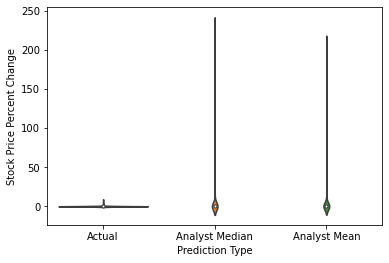

In [68]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Actual', 'Analyst Median', 'Analyst Mean']]).dropna())
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
plt.show()

In [73]:
z_scores = stats.zscore(analysts_percent['Analyst Median'].dropna())

abs_z_scores = np.abs(z_scores)
medians_no_outliers = analysts_percent['Analyst Median'].dropna()[abs_z_scores < 3]

In [72]:
z_scores = stats.zscore(analysts_percent['Analyst Mean'].dropna())

abs_z_scores = np.abs(z_scores)
means_no_outliers = analysts_percent['Analyst Mean'].dropna()[abs_z_scores < 3]

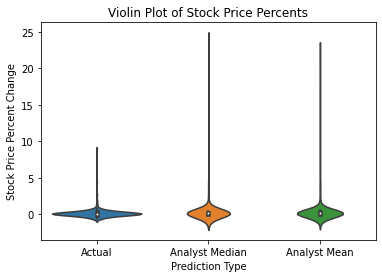

In [76]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([analysts_percent['Actual'],medians_no_outliers, means_no_outliers], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percents")
plt.show()

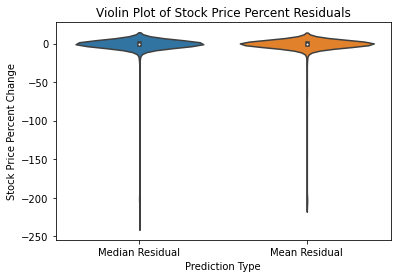

In [19]:
analysts_percent['Median Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Median"], axis =1)
analysts_percent['Mean Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Mean"], axis =1)

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Median Residual', 'Mean Residual']]))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

In [128]:
print(analysts_percent['Median Residual'].describe())
print()
print(analysts_percent['Mean Residual'].describe())

count    474.000000
mean      -1.770291
std       17.214635
min     -231.820000
25%       -0.278764
50%       -0.035162
75%        0.182663
max        4.721649
Name: Median Residual, dtype: float64

count    474.000000
mean      -1.714790
std       16.531061
min     -208.660000
25%       -0.286937
50%       -0.030198
75%        0.193663
max        4.721649
Name: Mean Residual, dtype: float64


Residual = Actual - Predicted
It looks like they tend to overshoot. TODO: Maybe perform hypothesis test here?

In [169]:
stats.ttest_1samp(a=analysts_percent['Median Residual'].dropna(), popmean=0).pvalue/2

0.012813095635420874

In [172]:
stats.ttest_1samp(analysts_percent['Mean Residual'].dropna(), popmean=0).pvalue/2

0.01218801191734196

In [56]:
z_scores = stats.zscore(analysts_percent['Median Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_median = analysts_percent['Median Residual'].dropna()[abs_z_scores < 3]


In [57]:
z_scores = stats.zscore(analysts_percent['Mean Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_mean = analysts_percent['Mean Residual'].dropna()[abs_z_scores < 3]


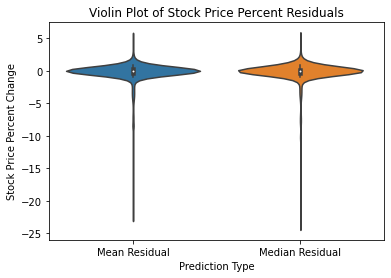

In [58]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([no_outliers_mean, no_outliers_median], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

In [59]:
stats.ttest_1samp(a=no_outliers_median, popmean=0).pvalue/2

0.0011165811457134014

In [60]:
stats.ttest_1samp(a=no_outliers_mean, popmean=0).pvalue/2

0.00045330492452277753